In [1]:
import pickle 

from pprint import pprint
import pandas as pd
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
DATA_PATH = "../data/datasets/tfidf/"
df = pd.read_csv('../data/datasets/contents.csv', dtype={'Category': 'category'})

with open(DATA_PATH+'features_train.pickle', 'rb') as data:
    features_train = pickle.load(data)

with open(DATA_PATH+'labels_train.pickle', 'rb') as data:
    labels_train = pickle.load(data)

with open(DATA_PATH+'features_test.pickle', 'rb') as data:
    features_test = pickle.load(data)

with open(DATA_PATH+'labels_test.pickle', 'rb') as data:
    labels_test = pickle.load(data)


In [3]:
features_train = features_train[:10_000]
labels_train = labels_train[:10_000]


In [4]:
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [5]:
# Random Search
C = [.0001, .001, .01]
gamma = [.0001, .001, .01, .1, 1, 10, 100]
degree = [1, 2, 3, 4, 5]
kernel = ['linear', 'rbf', 'poly']
probability = [True]

random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [6]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 27.0min finished


RandomizedSearchCV(cv=3, estimator=SVC(random_state=8), n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   random_state=8, scoring='accuracy', verbose=1)

In [7]:
print("The best hyperparameters from Grid Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)
best_svc = random_search.best_estimator_


The best hyperparameters from Grid Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.6550006530347097


In [8]:
# FIT
best_svc.fit(features_train, labels_train)

svc_pred = best_svc.predict(features_test)

In [9]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.9955


In [10]:
# Test accuracy
# Acc: 0.53
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.6718888888888889


In [11]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))


Classification report
              precision    recall  f1-score   support

           0       0.72      0.66      0.69     20048
           1       0.64      0.82      0.72     20732
           2       0.22      0.00      0.01      4220

    accuracy                           0.67     45000
   macro avg       0.53      0.49      0.47     45000
weighted avg       0.64      0.67      0.64     45000



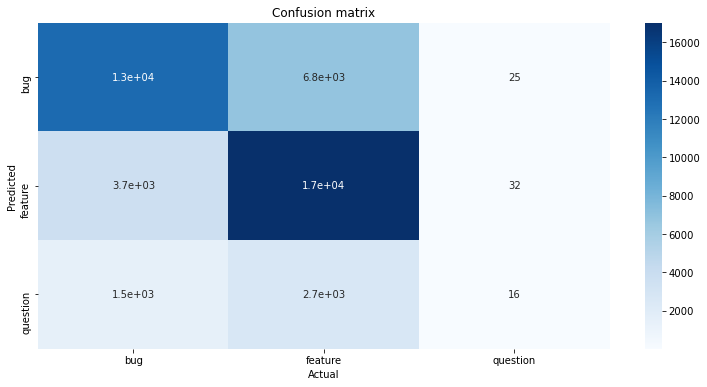

In [12]:
aux_df = pd.DataFrame([['bug', 0], ['feature', 1], ['question', 2]], columns=['Category', 'Category_Code'])

conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()


In [13]:
# Default parameters SVM
# Acc: 0.
base_model = svm.SVC(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))


0.7174

In [14]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])


In [15]:
with open('../models/best_svc.pickle', 'wb') as output:
    pickle.dump(best_svc, output)
    
with open('../models/df_models_svc.pickle', 'wb') as output:
    pickle.dump(df_models_svc, output)